# Setup

## Libraries

In [1]:
# Import libraries
import numpy as np
import math
import pandas as pd
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
import seaborn as sns

## Pull & Process Data

In [2]:
# Pull bond data from csv
selectedBonds = pd.read_csv('https://docs.google.com/uc?export=download&id=1lnA-abWvuwZBovFudRFd3AhMgW5a9WLn')

# Add column titles
columnTitles = ['Date', 'Bond', 'Price', 'Coupon', 'Maturity']
selectedBonds.columns = columnTitles

# Format the date and maturity date
selectedBonds['Date'] = pd.to_datetime(selectedBonds['Date'], format='%Y-%m-%d')
selectedBonds['Maturity'] = pd.to_datetime(selectedBonds['Maturity'], format='%Y-%m-%d')

# 4a. Yield to Maturity

## Find Dirty Price

In [3]:
# Function for finding the dirty price of the bond
def find_dirty_price(bond):
  # Pull bond data
  date = bond['Date'].values[0]
  coupon = bond['Coupon'].values[0]
  maturity = bond['Maturity'].values[0]
  price = bond['Price'].values[0]

  # Find when the last coupon occured
  lastCoupon = maturity
  while date < lastCoupon:
    lastCoupon = lastCoupon - pd.DateOffset(months=6)

  # Find the days since the last coupon
  daysSinceLastCoupon = (date - lastCoupon)

  # Calculated the dirty price from the clean price and accrued interest
  dirtyPrice = price + (daysSinceLastCoupon.days / 365) * coupon * 100

  return dirtyPrice


## Find Yield to Maturity

In [4]:
# Function for finding yield to maturity
def find_yield_to_maturity(bond):
  # Pull bond data
  date = bond['Date'].values[0]
  coupon = bond['Coupon'].values[0]
  maturity = bond['Maturity'].values[0]

  # Find the dirty price
  dirtyPrice = find_dirty_price(bond)

  # Adjust coupon rate to be semi-annual and as a dollar value
  coupon = coupon / 2 * 100

  # Calculate coupon dates
  periods = 0
  couponDate = maturity
  while date < couponDate:
    couponDate = couponDate - pd.DateOffset(months=6)
    periods += 1

  # Calculate the cash flow at each date
  cashFlows = [coupon] * (periods - 1) + [coupon + 100]
  cashFlowDates = []
  for i in range(periods):
    cashFlowDates.append(couponDate + (i+1)*pd.DateOffset(months=6))

  # Set up function for ytm based on cash flows and dirty price
  def ytm_function(y):
    return sum([cashFlows[t] / (1 + y)**(((cashFlowDates[t]-date).days) / 365) for t in range(periods)]) - dirtyPrice

  # Start with an initial guess for ytm
  ytm_guess = 0.05
  # Solve for ytm
  ytm = fsolve(ytm_function, ytm_guess)[0]

  return ytm


## Calculate and Plot Yield to Maturity

In [5]:
# Define ytm dataframe
ytms = pd.DataFrame(columns=['Date', 'Bond', 'Maturity', 'Yield to Maturity'])

# Iterate through the different dates of data
for date in selectedBonds['Date'].unique():
  # Pull bond data for the selected date
  dailyBonds = selectedBonds[selectedBonds['Date'] == date]

  # Iterate through the different bonds
  for bond in dailyBonds['Bond'].unique():
    # Save ytm to ytms dataframe
    ytms = pd.concat([ytms, pd.DataFrame([[date, bond, dailyBonds[dailyBonds['Bond'] == bond]['Maturity'].values[0], find_yield_to_maturity(dailyBonds[dailyBonds['Bond'] == bond])]], columns=['Date', 'Bond', 'Maturity', 'Yield to Maturity'])])

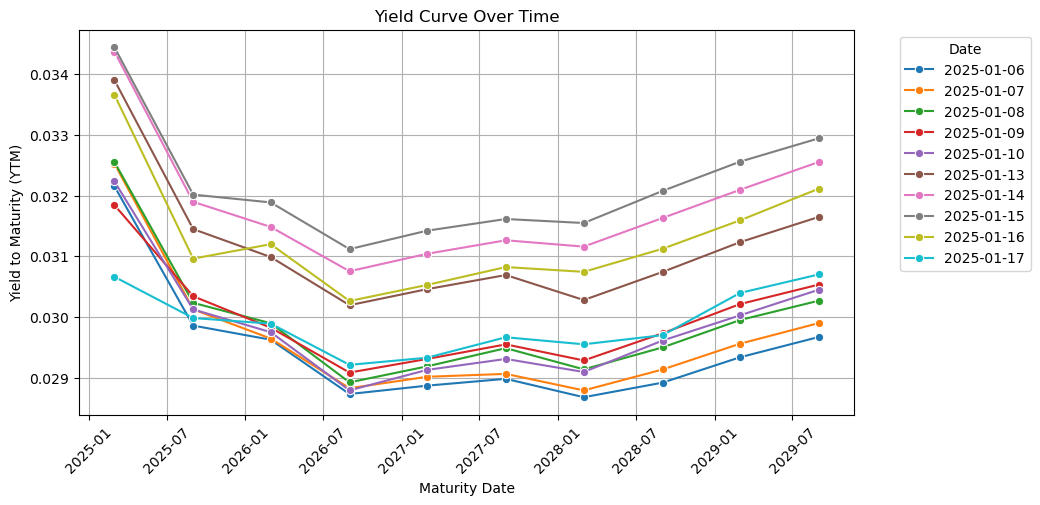

In [6]:
# Reset the ytm index
ytms = ytms.reset_index(drop=True)

# Set up ytm plot
plt.figure(figsize=(10, 5))
sns.lineplot(data=ytms, x="Maturity", y="Yield to Maturity", hue="Date", marker="o")

# Format plot
plt.xlabel("Maturity Date")
plt.ylabel("Yield to Maturity (YTM)")
plt.title("Yield Curve Over Time")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(title="Date", handles=plt.gca().get_lines(), labels=[pd.to_datetime(d).strftime('%Y-%m-%d') for d in ytms['Date'].unique()], bbox_to_anchor=(1.05, 1), loc='upper left')

# Show plot
plt.show()


# 4b. Spot Rates

## Find Spot Rates

In [7]:
# Function for finding spot rates
def bootstrap_spot_rates(dailyBonds):
  # Set up iteratable to index spot rates
  i = 0
  # Set up list of spot rates for each bond
  spotRates = []

  # Iterate through the bonds
  for dailyBond in dailyBonds['Bond'].unique():
    # Pull the bond data
    bond = dailyBonds[dailyBonds['Bond'] == dailyBond]
    coupon = bond['Coupon'].values[0]
    maturity = bond["Maturity"].values[0]

    # Find the dirty price
    dirtyPrice = find_dirty_price(bond)

    # Adjust coupon rate to be semi-annual and as a dollar value
    coupon = coupon / 2 * 100

    # Calculate coupon dates and cash flows
    periods = 0
    couponDate = maturity
    while date < couponDate:
      couponDate = couponDate - pd.DateOffset(months=6)
      periods += 1

    cashFlows = [coupon] * (periods - 1) + [coupon + 100]
    cashFlowDates = []
    for i in range(periods):
      cashFlowDates.append(couponDate + (i+1)*pd.DateOffset(months=6))

    # If this is the first bond (i.e. a zero coupon bond)
    if i == 0:
      # Solve directly since there's no coupons
      S = ((100 + coupon) / dirtyPrice) ** (1 / ((cashFlowDates[0]-date).days / 365)) - 1

      # Add it to the spot rate list
      spotRates.append(S)
    # If the bond has coupons
    else:
      # Use previous spot rates to discount cash flows
      discounted_coupons = sum([cashFlows[t] / (1 + spotRates[t])**(((cashFlowDates[t]-date).days) / 365) for t in range(periods-1)])

      # Solve for the new spot rate
      S = ((100 + coupon) / (dirtyPrice - discounted_coupons)) ** (1 / ((cashFlowDates[periods-1]-date).days / 365)) - 1

      # Add it to the spot rate list
      spotRates.append(S)

    # Iterate forwards by one
    i = i + 1

  return spotRates

## Calculate and Plot Spot Rates

In [8]:
# Sort the selected bonds by date and maturity
selectedBonds = selectedBonds.sort_values(by=['Date', 'Maturity'])
# Reset index
selectedBonds = selectedBonds.reset_index(drop=True)

# Set up dataframe for spot rates
spotRates = pd.DataFrame(columns=['Date', 'Bond', 'Maturity', 'Spot Rate'])

# For each of the days of data
for date in selectedBonds['Date'].unique():
  # Select the bonds for that date
  dailyBonds = selectedBonds[selectedBonds['Date'] == date]

  # Find the spot rates for that days bond details
  dailySpotRates = bootstrap_spot_rates(dailyBonds)

  # Save spot rates to the larger dataframe
  for i in range(len(dailyBonds['Bond'].unique())):
    spotRates = pd.concat([spotRates, pd.DataFrame([[date, dailyBonds['Bond'].unique()[i], dailyBonds['Maturity'].unique()[i], dailySpotRates[i]]], columns=['Date', 'Bond', 'Maturity', 'Spot Rate'])])


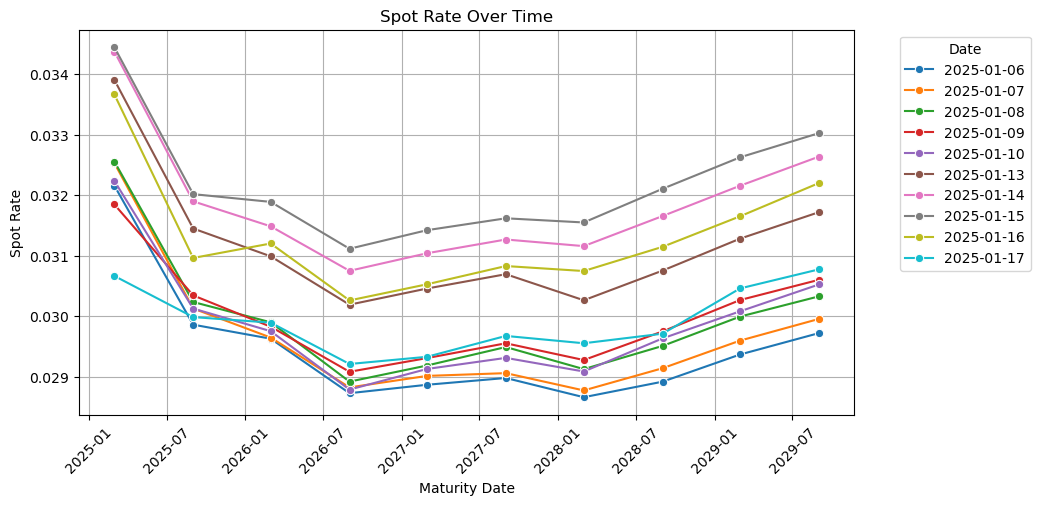

In [9]:
spotRates = spotRates.reset_index(drop=True)

# Plot
plt.figure(figsize=(10, 5))
sns.lineplot(data=spotRates, x="Maturity", y="Spot Rate", hue="Date", marker="o")

# Format plot
plt.xlabel("Maturity Date")
plt.ylabel("Spot Rate")
plt.title("Spot Rate Over Time")
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.grid(True)
plt.legend(title="Date", handles=plt.gca().get_lines(), labels=[pd.to_datetime(d).strftime('%Y-%m-%d') for d in ytms['Date'].unique()], bbox_to_anchor=(1.05, 1), loc='upper left')

# Show plot
plt.show()


# 4c. Forward Rates

## Find Forward Rates

In [10]:
# Function for finding forward rates
def calculate_forward_rates(spotRates, times):
  # Set up list for forward rates
  forwardRatesList = []

  # Iterate through the spot rates
  for i in range(len(spotRates)-1):
    # Calculate forward rate from spot rates
    forwardRate = ((1 + spotRates[i+1])**(2*times[i+1]) / (1 + spotRates[i])**(2*times[i]))**(1 / (2*(times[i+1] - times[i]))) - 1
    # Add forward rate to list
    forwardRatesList.append(forwardRate)
  return forwardRatesList

# Set up larger dataframe for all forward rates
forwardRates = pd.DataFrame(columns=['Date', 'Bond1', 'Bond2', 'Maturity1', 'Maturity2', 'Forward Rate'])

# Pull on spot rates with maturity in march (i.e. spaced 1 year apart)
filteredSpotRates = spotRates[spotRates['Maturity'].dt.month == 3]

# Iterate through each day of data
for date in filteredSpotRates['Date'].unique():
  # Pull the spot rates for that day
  dailySpotRates = filteredSpotRates[filteredSpotRates['Date'] == date].sort_values(by='Maturity')

  # Pull the spot rate values and maturities
  spotRateValues = dailySpotRates['Spot Rate'].values
  maturities = dailySpotRates['Maturity'].values

  # Calculate days between maturity and date the data was pulled
  times = [(maturity - dailySpotRates['Date'].iloc[0]).days / 365 for maturity in maturities]

  # Calculate forward rates
  dailyForwardRates = calculate_forward_rates(spotRateValues, times)

  # Add the forward rates to the larger dataframe
  for i in range(len(dailyForwardRates)):
    forwardRates = pd.concat([forwardRates, pd.DataFrame([[date, dailySpotRates['Bond'].iloc[i], dailySpotRates['Bond'].iloc[i+1], dailySpotRates['Maturity'].iloc[i], dailySpotRates['Maturity'].iloc[i+1], dailyForwardRates[i]]], columns=forwardRates.columns)])


## Plot Forward Rates

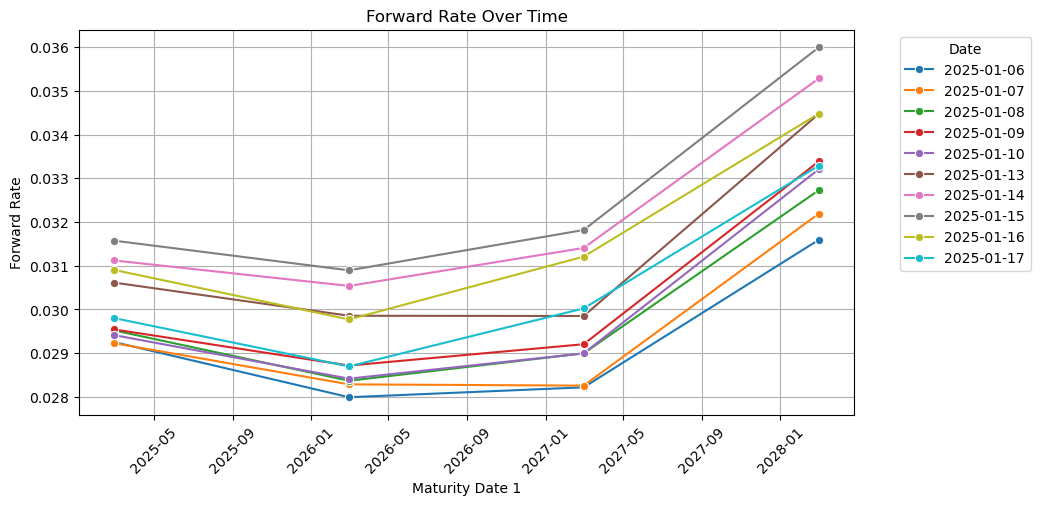

In [11]:
forwardRates = forwardRates.reset_index(drop=True)

# Plot forward rates
plt.figure(figsize=(10, 5))
sns.lineplot(data=forwardRates, x="Maturity1", y="Forward Rate", hue="Date", marker="o")

# Format plot
plt.xlabel("Maturity Date 1")
plt.ylabel("Forward Rate")
plt.title("Forward Rate Over Time")
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.grid(True)
plt.legend(title="Date", handles=plt.gca().get_lines(), labels=[pd.to_datetime(d).strftime('%Y-%m-%d') for d in ytms['Date'].unique()], bbox_to_anchor=(1.05, 1), loc='upper left')

# Show plot
plt.show()

# 5. Covariance Matrix

## Yield to Maturity Covariance

In [12]:
# Pull the ytms with a maturity in March (i.e. 1 year apart)
filteredYTMs = ytms[ytms['Maturity'].dt.month == 3]

# Pivot the ytm data
pivotFilteredYTMs = filteredYTMs.pivot(index='Date', columns='Bond', values='Yield to Maturity').sort_index()

# Calculate the time series for the random variables
ytmLogReturns = np.log(pivotFilteredYTMs.shift(-1) / pivotFilteredYTMs)

# Drop the last row of blanks
ytmLogReturns = ytmLogReturns.dropna()

# Calculate the covariance matrix
ytmCovMatrix = ytmLogReturns.cov()

# Print the covariance matrix
print("Covariance matrix: \n", ytmCovMatrix,"\n")

# Calculate the eigenvalues and eigenvectors
ytmEigenvalues, ytmEigenvectors = np.linalg.eig(ytmCovMatrix)
ytmNorms = np.linalg.norm(ytmEigenvectors, axis=0)
normalizedytmEigenvectors = ytmEigenvectors / ytmNorms

# Print the eigenvalues and eigenvectors
print("Eigenvalues: \n", ytmEigenvalues,"\n")
print("Eignevectors: \n", normalizedytmEigenvectors)


Covariance matrix: 
 Bond          CA135087K528  CA135087L518  CA135087M847  CA135087P576  \
Bond                                                                   
CA135087K528      0.001563      0.000861      0.000865      0.000844   
CA135087L518      0.000861      0.000558      0.000583      0.000572   
CA135087M847      0.000865      0.000583      0.000628      0.000613   
CA135087P576      0.000844      0.000572      0.000613      0.000616   
CA135087Q988      0.000838      0.000576      0.000624      0.000624   

Bond          CA135087Q988  
Bond                        
CA135087K528      0.000838  
CA135087L518      0.000576  
CA135087M847      0.000624  
CA135087P576      0.000624  
CA135087Q988      0.000637   

Eigenvalues: 
 [3.74028875e-03 2.42017387e-04 1.30041054e-05 5.82844957e-06
 1.45758747e-06] 

Eignevectors: 
 [[ 0.61619178 -0.76690116 -0.1506073  -0.09420817 -0.02474978]
 [ 0.38285574  0.10681348  0.59189219  0.58808587  0.38187826]
 [ 0.40042239  0.30715736  0.509

## Forward Rates Covariance

In [13]:
# Pivot the forward rate data
pivotForwardRates = forwardRates.pivot(index='Date', columns=['Bond1', 'Bond2'], values='Forward Rate').sort_index()

# Calculate the time series for the random variables
forwardRateLogReturns = np.log(pivotForwardRates.shift(-1) / pivotForwardRates)

# Drop the last row of blanks
forwardRateLogReturns = forwardRateLogReturns.dropna()

# Calculate the covariance matrix
forwardCovMatrix = forwardRateLogReturns.cov()

# Print the covariance matrix
print("Covariance matrix: \n", forwardCovMatrix,"\n")

# Calculate the eigenvalues and eigenvectors
forwardEigenvalues, forwardEigenvectors = np.linalg.eig(forwardCovMatrix)
forwardNorms = np.linalg.norm(forwardEigenvectors, axis=0)
normalizedForwardEigenvectors = forwardEigenvectors / forwardNorms


# Print the eigenvalues and eigenvectors
print("Eigenvalues: \n", forwardEigenvalues,"\n")
print("Eignevectors: \n", normalizedForwardEigenvectors)

Covariance matrix: 
 Bond1                     CA135087K528 CA135087L518 CA135087M847 CA135087P576
Bond2                     CA135087L518 CA135087M847 CA135087P576 CA135087Q988
Bond1        Bond2                                                           
CA135087K528 CA135087L518     0.000493     0.000584     0.000522     0.000556
CA135087L518 CA135087M847     0.000584     0.000765     0.000620     0.000737
CA135087M847 CA135087P576     0.000522     0.000620     0.000727     0.000624
CA135087P576 CA135087Q988     0.000556     0.000737     0.000624     0.000772 

Eigenvalues: 
 [2.53098380e-03 1.57445219e-05 5.65390579e-05 1.54440632e-04] 

Eignevectors: 
 [[ 0.42641058  0.56995636  0.7020687   0.02057447]
 [ 0.53736995 -0.71058561  0.23917621  0.38612998]
 [ 0.49311071 -0.13969719 -0.16137207 -0.84337749]
 [ 0.53502278  0.38820424 -0.6510402   0.37308812]]
